<a href="https://colab.research.google.com/github/FabianoVeglianti/Architecture_Selection_Using_Infinite_Width_Limit_Neural_Network/blob/main/simulazioni_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q --upgrade pip
!pip install -q --upgrade jax[cuda11_cudnn82] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -q tensorflow-datasets
!pip install -q git+https://www.github.com/google/neural-tangents

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 27.0 MB/s eta 0:00:00


In [2]:
import jax

from jax import jit
from jax import grad
from jax import random
import jax.numpy as jnp
from jax.nn import log_softmax
from jax.example_libraries import optimizers
import neural_tangents as nt
from neural_tangents import stax

In [3]:
from tensorflow_probability import math as tfmath

In [4]:
import tensorflow as tf
import numpy as np
from numpy.random import Generator
from matplotlib import pyplot as plt
import math
import pandas as pd
from argparse import Namespace
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from google.colab import files
from scipy.stats import norm, gmean
import time
from google.colab import drive
drive.mount('/content/drive')
import os
import json

Mounted at /content/drive


In [5]:
args = Namespace(
    # Data and Path information
    n_sample = 100,
    d = 10, #n_0
    n_L_plus_1 = 1,
    significance = 0.05, #pvalue
    percentage_interval = 0.2   #backtesting
)

# Tools

## MLP

In [6]:
# TENSORFLOW - KERAS IMPLEMENTATION

class MLP(tf.keras.Sequential):
  def __init__(self, L, n_list, activation, Cb, Cw, seed = 100, use_bias = True, use_generator_init = False):
    """
    Args:
      use_bias (bool): attiva/disattiva l'uso dei bias nei layers
      use_generator_init (bool):
        se False usa l'inizializzazione di Gianluca
        se True usa l'inizializzazione descritta in Delving Deep into Rectifiers
    """

    super().__init__()
    self.generator = np.random.default_rng(seed)
    self.L = L
    self.n_list = n_list
    self.activation = activation
    self.Cb = Cb
    self.Cw = Cw

    index = 0
    seeds_needed = 2*(L + 1)
    seeds = self.generator.integers(1,1000000, size=seeds_needed)

    #Creo gli inizializzatori -> oggetti necessari a inizializzare i pesi W (chiamati kernel) e i bias
    kernel_initializers_list = []
    bias_initializers_list = []
    if use_generator_init:
      kernel_initializers_list.append(tf.keras.initializers.RandomNormal(0, math.sqrt(1/n_list[0]), seed = seeds[index]))
      index +=1
      bias_initializers_list.append(tf.keras.initializers.RandomNormal(0,0, seed = seeds[index]))
      index += 1
    else:
      kernel_initializers_list.append(tf.keras.initializers.RandomNormal(0, math.sqrt(Cw/n_list[0]), seed = seeds[index]))
      index += 1
      bias_initializers_list.append(tf.keras.initializers.RandomNormal(0,stddev=math.sqrt(Cb), seed = seeds[index]))
      index += 1

    for l in range(1, L):
      if use_generator_init:
        kernel_initializers_list.append(tf.keras.initializers.RandomNormal(0, math.sqrt(2/n_list[l]), seed = seeds[index]))
        index += 1
        bias_initializers_list.append(tf.keras.initializers.RandomNormal(0,0, seed = seeds[index]))
        index += 1
      else:
        kernel_initializers_list.append(tf.keras.initializers.RandomNormal(0, math.sqrt(Cw/n_list[l]), seed = seeds[index]))
        index += 1
        bias_initializers_list.append(tf.keras.initializers.RandomNormal(0,stddev=math.sqrt(Cb), seed = seeds[index]))
        index += 1

    if use_generator_init:
      kernel_initializers_list.append(tf.keras.initializers.RandomNormal(0, math.sqrt(2/n_list[L]), seed = seeds[index]))
      index +=1
      bias_initializers_list.append(tf.keras.initializers.RandomNormal(0,0, seed = seeds[index]))
      index += 1
    else:
      kernel_initializers_list.append(tf.keras.initializers.RandomNormal(0, math.sqrt(Cw/n_list[L]), seed = seeds[index]))
      index += 1
      bias_initializers_list.append(tf.keras.initializers.RandomNormal(0,stddev=math.sqrt(Cb), seed = seeds[index]))
      index += 1




    #Aggiungo gli strati al modello: Dense e' il classico strato pieno di neuroni
    self.add(tf.keras.layers.Dense(n_list[1], input_shape=[n_list[0]], activation = activation, use_bias = use_bias, kernel_initializer = kernel_initializers_list[0],
              bias_initializer = bias_initializers_list[0]))
    for l in range(1, L):
        self.add(tf.keras.layers.Dense(n_list[l+1], activation=activation, use_bias = use_bias, kernel_initializer = kernel_initializers_list[l],
                  bias_initializer = bias_initializers_list[l]))
    self.add(tf.keras.layers.Dense(n_list[L+1], use_bias = use_bias, kernel_initializer = kernel_initializers_list[L],
                  bias_initializer = bias_initializers_list[L]))
    #print("Created MLP")
    #print(self.summary())


In [7]:
# NEURAL-TANGENTS IMPLEMENTATION

def mlp_neural_tangents(
    Cw_sqrt,
    Cb_sqrt,
    n_list,
    L,
    parameterization
):
    """Construct fully connected NN model and infinite width NTK & NNGP kernel
       function.

    Args:
        Cw_sqrt è la std dei pesi W
        Cb_sqrt è la std dei bias b
        L è il numero di hidden layers
        n_list è una lista di L interi. n_list[i] è il numero di neuroni allo strato (i+1)-esimo - i neuroni allo strato 0 non vanno specificati
        parameterization (string): Parameterization string, 'ntk' or 'standard'.
        Dettagli riguardo la parametrizzazione in: https://neural-tangents.readthedocs.io/en/latest/_autosummary/neural_tangents.stax.Dense.html#neural_tangents.stax.Dense

    Returns:
        `(init_fn, apply_fn, kernel_fn)`
    """
    layers_list = [stax.Dense(n_list[0], Cw_sqrt, Cb_sqrt, parameterization=parameterization)]

    def layer_block(width):
        return stax.serial(stax.Relu(), stax.Dense(width, Cw_sqrt, Cb_sqrt, parameterization=parameterization))

    for i in range(L-1):
        layers_list += [layer_block(n_list[i+1])]

    layers_list += [stax.Relu(), stax.Dense(1, Cw_sqrt, Cb_sqrt, parameterization=parameterization)]

    # print (f"---- layer list is {layers_list} ------")

    init_fn, apply_fn, kernel_fn = stax.serial(*layers_list)

    apply_fn = jit(apply_fn)

    return init_fn, apply_fn, kernel_fn   #apply_fn is f_hat


In [8]:
def create_constant_widths_list(L,n):
  """
  Creates a list of values representing the widths of layers of a neural network.
  All widths are the same except for the first and the last.
  Args:
    L (int): number of hidden layers
    n (int): starting value
  Returns:
    layer_widths ([int, int ...]): list of layer widths. Input layer and output layer widths are args.d and args.n_L_plus_1
      for the hidden layers the widths are computed using h_i(n) = n forall i
  """
  layer_widths = []
  layer_widths.append(args.d)
  for l in range(L):
    layer_widths.append(n)
  layer_widths.append(args.n_L_plus_1)
  return layer_widths


## DatasetHandler

In [91]:

class DatasetHandler():
  """
  list of (possible) class attributes:
    generator
    self.mlp_generator_L
    self.mlp_generator_activation
    self.mlp_generator_Cb
    self.mlp_generator_Cw
    self.y_mean
    self.is_centered
    self.dataset

  list of class methods:
    create_dataset_from_MLP
    create_dataset_from_MLP_given_input
    create_input
    download_dataset_description
    get_dataset_description_as_dataframe
    get_dataset_with_gaussian_limit
    get_max_norm_X
    get_uncentered_dataset
    get_x1_as_array
    get_x2_as_array
    get_y_as_array
    get_y_stddev
    reset_scaled_X
    save_dataset_description_on_cloud
    set_dataset
    set_generator_params
    set_max_norm_X_to_1
  """

  def __init__(self, seed = 147):
    self.generator = np.random.default_rng(seed)

  #method
  def create_dataset_from_MLP(self, mlp, seed = 147, add_noise = False, noise = [], centered = True):
    """
    Args:
      n_sample (int): number of sample in the output dataset
      mlp (MLP): y_i = mlp(x_i)
      seed (int): seed of the PRNG
      add_noise (bool): flag for noise
      noise: ([float,float,...]): noise values
      centered: (bool): flag for centered dataset
    Returns:
      dataset (pd.Dataframe): a dataset of shape (n_sample, d + 1)
      y_mean (float): mean value if centered is set to True
    """
    self.mlp_generator_L = mlp.L
    self.mlp_generator_activation = mlp.activation
    self.mlp_generator_n_list = mlp.n_list
    self.mlp_generator_Cb = mlp.Cb
    self.mlp_generator_Cw = mlp.Cw
    self.centered = centered


    #np.random.seed = seed
    #print(np.random.seed)

    X = self.generator.uniform(low = -6.0, high = 6.0, size = (args.n_sample, args.d))
    #for i in range(X.shape[0]):
    #  X[i] = X[i]/np.linalg.norm(X[i], ord=2)

    y = mlp(X).numpy().reshape((args.n_sample, args.n_L_plus_1))

    if add_noise:
      if len(noise) == 0:
        noise = self.generator.normal(args.noise_mean, args.noise_std, size = (args.n_sample, args.n_L_plus_1))
      else:
        noise = np.array(noise)
      y = y + noise
    if centered:
      y_mean = np.mean(y, axis = 0).reshape(args.n_L_plus_1, -1)
      self.y_mean = y_mean
      y = y-self.y_mean
    else:
      y_mean = None

    data = {}
    for i in range(args.d):
      name_feature = "x" + str(i+1)
      data[name_feature] = X[:,i]
    for j in range(args.n_L_plus_1):
      name_output = "y" + str(j+1)
      data[name_output] = y[:,j]
    dataset = pd.DataFrame.from_dict(data)

    self.dataset = dataset
    return dataset, y_mean

  #method
  def create_dataset_from_MLP_given_input(self, mlp, input, add_noise = False, noise = [], centered = True):
    self.mlp_generator_L = mlp.L
    self.mlp_generator_activation = mlp.activation
    self.mlp_generator_n_list = mlp.n_list
    self.mlp_generator_Cb = mlp.Cb
    self.mlp_generator_Cw = mlp.Cw
    self.centered = centered
    X = input.to_numpy()

    y = mlp(X).numpy().reshape((args.n_sample, args.n_L_plus_1))

    if add_noise:
      if len(noise) == 0:
        noise = self.generator.normal(args.noise_mean, args.noise_std, size = (args.n_sample, args.n_L_plus_1))
      else:
        noise = np.array(noise)
      y = y + noise
    if centered:
      y_mean = np.mean(y, axis = 0).reshape(args.n_L_plus_1, -1)
      self.y_mean = y_mean
      y = y-self.y_mean
    else:
      y_mean = None

    data = {}
    for i in range(args.d):
      name_feature = "x" + str(i+1)
      data[name_feature] = X[:,i]
    for j in range(args.n_L_plus_1):
      name_output = "y" + str(j+1)
      data[name_output] = y[:,j]

    dataset = pd.DataFrame.from_dict(data)

    self.dataset = dataset
    return dataset, y_mean

  #method
  def create_input(self):
    X = self.generator.uniform(low = -6.0, high = 6.0, size = (args.n_sample, args.d))

    input_dict = {}
    for i in range(args.d):
      name_feature = "x" + str(i+1)
      input_dict[name_feature] = X[:,i]

    input_df = pd.DataFrame.from_dict(input_dict)
    return input_df


  def create_input_hypersphere(self, radius, surface = False):
    """
    Dato il raggio (radius) genera args.n_sample punti nella ipersfera di dimensione
    args.d centrata nell'origine.
    RATIONALE: https://math.stackexchange.com/questions/87230/picking-random-points-in-the-volume-of-sphere-with-uniform-probability/87238#87238
    """
    if not surface:
      U = self.generator.uniform(low = 0, high = 1, size = (args.n_sample, 1))
      X = self.generator.normal(loc = 0, scale = 1, size = (args.n_sample, args.d))
      norm_X = np.linalg.norm(X, ord=2, axis = 1).reshape(-1,1)

      within_sphere_X = radius * U ** (1/args.d) * X / norm_X

      input_dict = {}
      for i in range(args.d):
        name_feature = "x" + str(i+1)
        input_dict[name_feature] = within_sphere_X[:,i]

      input_df = pd.DataFrame.from_dict(input_dict)
      return input_df
    else:
      X = self.generator.normal(loc = 0, scale = 1, size = (args.n_sample, args.d))
      norm_X = np.linalg.norm(X, ord=2, axis = 1).reshape(-1,1)
      on_sphere_X = radius * X / norm_X
      input_dict = {}
      for i in range(args.d):
        name_feature = "x" + str(i+1)
        input_dict[name_feature] = on_sphere_X[:,i]

      input_df = pd.DataFrame.from_dict(input_dict)
      return input_df


  #method
  def create_correlated_input(self, normalized = True, radius = 1):
    #di default genera un vettore di variabili aleatorie gaussiano correlate
    #che poi viene normalizzato sulla ipersfera unitaria
    X_uncorrelated = self.generator.normal(loc = 0, scale = 1, size = (args.n_sample, args.d))

    # Step 1: Genera una matrice quadrata d x d
    random_matrix = self.generator.uniform(size =(args.d, args.d))

    # Step 2: Rendo la matrice simmetrica
    sym_matrix = (random_matrix + random_matrix.T) / 2.0

    # Step 3: Mi assicuro della semidefinita positivita
    eigenvalues, eigenvectors = np.linalg.eig(sym_matrix)
    min_eigenvalue = np.min(eigenvalues)
    if min_eigenvalue < 0:
        # Se l'autovalore più piccolo è negativo, sommo una matrice che lo rende positivo
        sym_matrix += -2 * min_eigenvalue * np.eye(args.d)

    # Step 4: effettuo la decomposizione di Cholesky
    cholesky_matrix = np.linalg.cholesky(sym_matrix)

    # Step 5: Moltiplico il vettore di normali standard scorrelati per la matrice di Cholesky
    X_correlated = np.dot(X_uncorrelated, cholesky_matrix.T)

    #Step 6 (opzionale): Normalizzazione
    if normalized:
      norm_X = np.linalg.norm(X_correlated, ord=2, axis = 1).reshape(-1,1)
      on_sphere_X = radius * X_correlated / norm_X

      input_dict = {}
      for i in range(args.d):
        name_feature = "x" + str(i+1)
        input_dict[name_feature] = on_sphere_X[:,i]

      input_df = pd.DataFrame.from_dict(input_dict)
      return input_df, sym_matrix
    else:
      input_dict = {}
      for i in range(args.d):
        name_feature = "x" + str(i+1)
        input_dict[name_feature] = X_correlated[:,i]

      input_df = pd.DataFrame.from_dict(input_dict)
      return input_df, sym_matrix



  #method
  def download_dataset_description(self):
    try:
      L = getattr(self, "mlp_generator_L")
      df = self.get_dataset_description_as_dataframe()
      activation = self.mlp_generator_activation
      n = self.mlp_generator_n_list[1]
      Cb = self.mlp_generator_Cb
      Cw = self.mlp_generator_Cw
      filename = ""
      filename += activation
      filename += "_" + str(L)
      filename += "_"+str(n)
      filename += "_"+str(Cb)
      filename += "_"+str(Cw)+"_dataset_description.csv"
      df.to_csv(filename, index=False)
      files.download(filename)
    except AttributeError:
      print("You have to call create_dataset_from_MLP before trying downloading.")

  #method
  def get_dataset_description_as_dataframe(self):
    y = self.get_y_as_array(self.dataset)
    if self.centered:
      y = y + self.y_mean
    y_mean = np.mean(y, axis = 0).reshape(args.n_L_plus_1, -1)
    y_var = np.var(y, axis = 0).reshape(args.n_L_plus_1, -1)
    columns=['activation', 'L', 'n', 'Cb', 'Cw']
    data = [self.mlp_generator_activation, self.mlp_generator_L,
                             self.mlp_generator_n_list[1], self.mlp_generator_Cb,
                             self.mlp_generator_Cw]
    for j in range(args.n_L_plus_1):
      name_y_mean = "y_mean" + str(j+1)
      name_y_var = "y_var" + str(j+1)
      columns.append(name_y_mean)
      columns.append(name_y_var)
      data.append(float(y_mean[j]))
      data.append(float(y_var[j]))

    df = pd.DataFrame(columns = columns)
    df.loc[len(df.index)] = data

    return df


  def get_dataset_with_gaussian_limit(self, mlp, input = None, scaled_input = None, use_scaled_input = False):
    #new_df = pd.DataFrame(columns=['x1', 'x2', 'L', 'activation', 'Cb', 'Cw', 'gaussian_limit_var', 'gaussian_limit_std'])
    new_df_rows =[]


    for index, row in input.iterrows():
      new_row = {}
      if use_scaled_input:
        x = (scaled_input.iloc[index]).to_numpy()
      else:
        x = (row[:]).to_numpy()
      new_row = (input.iloc[index]).to_dict()
      gaussian_limit_std = get_gaussian_limit_stddev_(mlp, x)
      gaussian_limit_var = gaussian_limit_std * gaussian_limit_std
      new_row['L'] = mlp.L
      new_row['activation'] = mlp.activation
      new_row['Cb'] = mlp.Cb
      new_row['Cw'] = mlp.Cw
      new_row['gaussian_limit_var'] = gaussian_limit_var
      new_row['gaussian_limit_std'] = gaussian_limit_std
      new_df_rows.append(new_row)
    new_df = pd.DataFrame(new_df_rows)
    return new_df

  #method
  def get_max_norm_X(self, dataset):
    columns = []
    for i in range(args.d):
      columns.append('x'+str(i+1))
    X = dataset[columns]
    max_norm_X = np.max(np.linalg.norm(X, ord=2, axis =1))
    return max_norm_X

  #method
  def get_uncentered_dataset(self):
    new_df = self.dataset.copy()
    if self.centered:
      return new_df
    else:
      y = self.get_y_as_array(new_df)
      y = y + self.y_mean
      new_df = new_df.assign(y=y)
      return new_df

  #method
  def get_x1_as_array(self, dataset):
    """
    Args:
      dataset (pd.Dataframe): a dataset with column names [x1, x2, y]
    Returns:
      x1 (np.ndarray): the first column of dataset
    """
    return dataset.x1.to_numpy()

  #method
  def get_x2_as_array(self, dataset):
    """
    Args:
      dataset (pd.Dataframe): a dataset with column names [x1, x2, y]
    Returns:
      x2 (np.ndarray): the second column of dataset
    """
    return dataset.x2.to_numpy()

  #method
  def get_y_as_array(self, dataset):
    """
    Args:
      dataset (pd.Dataframe): a dataset with column names [x1, x2, y]
    Returns:
      y (np.ndarray): the last column of dataset
    """
    columns = []
    for j in range(args.n_L_plus_1):
      columns.append("y" + str(j+1))

    return (dataset[columns]).to_numpy()

  #method
  def get_y_stddev(self):
    y = self.get_y_as_array(self.dataset)
    if self.centered:
      y = y + self.y_mean
    return np.sqrt(np.var(y))

  #method
  def reset_scaled_X(self, dataset, scale_factor):
    columns = []
    for i in range(args.d):
      columns.append('x'+str(i+1))
    X = dataset[columns]
    X = X * 1 / scale_factor
    dataset[columns] = X
    return dataset

  #method
  def save_dataset_description_on_cloud(self, basepath):
    try:
      L = getattr(self, "mlp_generator_L")
      df = self.get_dataset_description_as_dataframe()
      activation = self.mlp_generator_activation
      n = self.mlp_generator_n_list[1]
      Cb = self.mlp_generator_Cb
      Cw = self.mlp_generator_Cw
      path = basepath + str(L) + "_" + activation
      handle_dirs(path)
      filename = path + "/description.csv"
      with open(filename, 'w', encoding = 'utf-8-sig') as f:
        df.to_csv(f, index = False)
    except AttributeError:
      print("You have to call create_dataset_from_MLP before trying downloading.")

  #method
  def set_dataset(self, dataset, to_center): #da settare anche L, n, activation, Cb, Cw e centered
    if to_center:
      self.centered = True
      y = self.get_y_as_array(dataset)
      self.y_mean = np.mean(y, axis = 0).reshape(args.n_L_plus_1, -1)
      y = y - self.y_mean
      dataset = dataset.assign(y=y)
    self.dataset = dataset

  #method
  def set_generator_params(self, L, activation,Cb,Cw):
    self.mlp_generator_L = L
    self.mlp_generator_activation = activation
    self.mlp_generator_Cb = Cb
    self.mlp_generator_Cw = Cw

  #method
  def set_max_norm_X_to_val(self, dataset, val):
    new_dataset = dataset.copy()
    columns = []
    for i in range(args.d):
      columns.append('x'+str(i+1))
    X = new_dataset[columns]
    max_norm_X = np.max(np.linalg.norm(X, ord=2, axis =1))
    scale_factor = val / max_norm_X
    X = X * scale_factor
    new_dataset[columns] = X
    return new_dataset, scale_factor

In [38]:
def scatterplot3d_from_dataset(dataset, out_filename, dataset_handler):
  #usable only if dataset has columns ['x1', 'x2', 'y1']
  x1 = dataset_handler.get_x1_as_array(dataset)
  x2 = dataset_handler.get_x2_as_array(dataset)
  y1 = dataset_handler.get_y_as_array(dataset)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection = '3d')   # 3d projection


  pnt3d=ax.scatter(x1, x2, y1, c=y1)
  ax.set_xlabel('x1')                         # axis label
  ax.set_ylabel('x2')
  #ax.set_zlabel('y')
  ax.zaxis.set_ticklabels([])
  cbar=plt.colorbar(pnt3d)
  #plt.savefig(out_filename)
  plt.show()

#### TestPlotting

[[0.85588986]
 [2.0094154 ]
 [0.5948276 ]
 [1.2565928 ]
 [0.17053795]
 [0.89300495]
 [0.624489  ]
 [0.25452632]
 [0.7772016 ]
 [1.1235657 ]
 [0.9028956 ]
 [0.6561652 ]
 [0.43819958]
 [1.4768114 ]
 [0.40576154]
 [1.6064851 ]
 [0.58269066]
 [0.24501431]
 [0.26551723]
 [0.81852907]
 [0.83332115]
 [0.3739857 ]
 [0.6922546 ]
 [0.6343308 ]
 [0.3000332 ]
 [1.1801138 ]
 [1.2660351 ]
 [1.4614735 ]
 [0.41268784]
 [0.75863665]
 [1.1512246 ]
 [1.1276968 ]
 [0.24113715]
 [1.2873576 ]
 [0.72490484]
 [0.498545  ]
 [0.54035753]
 [0.8537286 ]
 [0.8365945 ]
 [0.2570963 ]
 [0.9270943 ]
 [1.2876313 ]
 [0.7654862 ]
 [1.3271704 ]
 [0.58916456]
 [0.63482136]
 [1.1773424 ]
 [1.616837  ]
 [0.7053667 ]
 [0.40374357]
 [1.2935007 ]
 [0.5207358 ]
 [0.9449524 ]
 [0.9933912 ]
 [0.6122033 ]
 [0.49792212]
 [0.8398151 ]
 [0.66710347]
 [0.11529106]
 [0.7703734 ]
 [1.0459323 ]
 [1.4716477 ]
 [0.46098405]
 [0.3888511 ]
 [0.33501923]
 [0.66109663]
 [1.7529242 ]
 [0.27620286]
 [0.6189665 ]
 [0.8733607 ]
 [0.73682266]
 [0.51

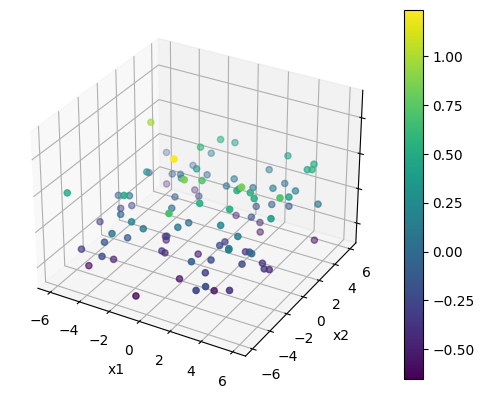

In [35]:
dataset_handler = DatasetHandler()
L = 5
width_list = create_constant_widths_list(L, 100)
mlp = MLP(L, width_list, "relu", 1, 1, seed = 100)
dataset, _ = dataset_handler.create_dataset_from_MLP(mlp, seed = 147)
scatterplot3d_from_dataset(dataset, "", dataset_handler)



(array([14., 11., 23., 17., 11.,  7., 10.,  5.,  1.,  1.]),
 array([-0.65512621, -0.46571377, -0.27630132, -0.08688889,  0.10252354,
         0.29193598,  0.48134843,  0.67076087,  0.86017329,  1.0495857 ,
         1.23899817]),
 <BarContainer object of 10 artists>)

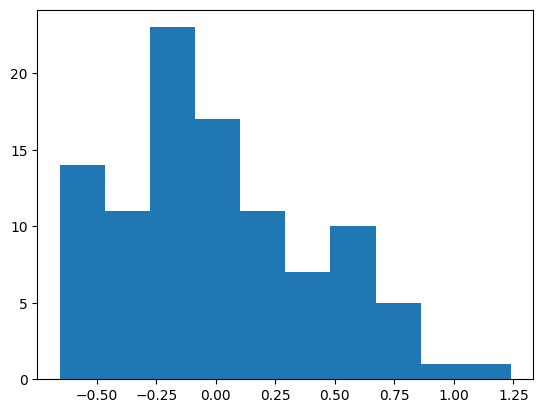

In [36]:
fig = plt.figure()
plt.hist(dataset.y1)

## Infinite Width MLP Variance Computing

In [40]:
vZ = np.arange(start = -10,stop = 10, step = 0.001)
vProb = tf.convert_to_tensor([norm.pdf(vZ[i]) for i in range(vZ.size)], dtype = tf.float32)
vZ = tf.convert_to_tensor(vZ, dtype = tf.float32)

def numerical_integration(vZ, vActiv, vProb):
  vF = np.multiply(vActiv, vProb)
  vH = np.diff(vZ)
  nPoints = vF.size
  dInteg_rectangle = np.sum(np.multiply(vF[1:nPoints],vH))
  return dInteg_rectangle

def get_gaussian_limit_stddev_(mlp, x):
  L = mlp.L
  Cb = mlp.Cb
  Cw = mlp.Cw
  if mlp.activation == 'relu':
    #print("relu")

    CollObs_0 = 1/mlp.n_list[0]*np.square(np.linalg.norm(x, ord=2))
    if Cw == 2:
      CollObs_L = Cb/2*L + CollObs_0
    else:
      CollObs_L = Cb/2*(1-math.pow((Cw/2), L))/(1-(Cw/2)) + math.pow(Cw/2, L)*CollObs_0
    var = Cb + Cw*CollObs_L
    #print("{}->{}".format(L, var))
    return np.sqrt(var)
  else:
    L = mlp.L
    Cb = mlp.Cb
    Cw = mlp.Cw
    #print(mlp.activation)
    activation_function = tf.keras.activations.get(mlp.activation)
    #input = tf.math.multiply(vZ, dC)
    f = lambda dC: tf.multiply(tf.math.square(activation_function(tf.math.multiply(vZ,dC))), vProb)

    #vZ = np.arange(start = -10,stop = 10, step = 0.001)

    #vProb = np.array([norm.pdf(vZ[i]) for i in range(vZ.size)])

    CollObs_0 = 1/mlp.n_list[0]*tf.math.square(tf.convert_to_tensor(np.linalg.norm(x, ord=2), dtype = tf.float32))
    dC = tf.math.sqrt(Cb + Cw*CollObs_0)
    CollObs_vec = []
    CollObs_vec.append(CollObs_0)


    for j in range(1, L+1):
      res = tfmath.trapz(f(dC), vZ)
      CollObs_vec.append(tfmath.trapz(f(dC), vZ))
      dC = tf.math.sqrt(Cb + Cw*CollObs_vec[j])

    return dC.numpy()



In [41]:
# Quando si possiede già un dataframe (df) con le varianze per ciascun x e ciascun mlp, si cerca
# nel dataframe anziché ricalcolarla.
def get_gaussian_limit_std_from_df(df, x, mlp):
  cond_L = df['L'] == mlp.L
  cond_activation = df['activation'] == mlp.activation
  cond_Cb = df['Cb'] == mlp.Cb
  cond_Cw = df['Cw'] == mlp.Cw
  cond = cond_L & cond_activation & cond_Cb & cond_Cw
  df_current_predictor = df[cond]

  columns_to_exclude = ['L', 'activation', 'Cb', 'Cw', 'gaussian_limit_var', 'gaussian_limit_std']
  all_columns = df_current_predictor.columns
  columns_to_select = [col for col in all_columns if col not in columns_to_exclude]
  dataset_cond = df_current_predictor[columns_to_select] == x
  cond = np.array([True for _ in range(dataset_cond.shape[0])])
  for i in range(dataset_cond.shape[1]):
    cond = cond & dataset_cond[dataset_cond.columns[i]]

  gaussian_limit_std = float((df_current_predictor[cond]).gaussian_limit_std)
  return gaussian_limit_std

## ScoreHandler

In [93]:
class Score_Handler:
  """
  list of class methods:
    compute_nloglike
  """


  #method
  def compute_nloglike(self, dataset_handler, gaussian_limit_json):
    output_dataset = pd.DataFrame(columns = ['L', 'activation', 'Cb', 'Cw', 'nloglike'])

    for json_obj in gaussian_limit_json:
      predictor = json_obj['predictor']
      K = jnp.array(json_obj['K'], dtype = "float32")

      y_np = (dataset_handler.dataset.iloc[:, -1*args.n_L_plus_1]).to_numpy()
      y = jnp.array(y_np).reshape(-1, args.n_L_plus_1)

      K_inv = jnp.linalg.inv(K)
      K_det = jnp.linalg.det(K)


      nloglike = 0.5 * jnp.matmul(jnp.matmul(jnp.transpose(y), K_inv), y) + 0.5*jnp.log(K_det) + y.shape[1]/2 * jnp.log(2*jnp.pi)

      output_dataset['L'] = predictor['L']
      output_dataset['activation'] = 'relu'
      output_dataset['Cb'] = predictor['Cb']
      output_dataset['Cw'] = predictor['Cw']
      print("Architettura:")
      print(predictor)
      print("nloglike={0:.6f}".format(nloglike.reshape(-1)[0]))
      print("")
      output_dataset['nloglike'] = float(nloglike)

    return output_dataset


# Testing

Creiamo una classe per gestire i dati di una simulazione su un dataset.

In [43]:
class MLPGeneratedDatasetSimulation:
  """ Class to collect results over 1 dataset

  list of class (possible) attributes:
    dataset_handler
    result_dataset

  list of class methods:
    create_from_csv                   @classmethod
    create_from_csv_with_results      @classmethod
    download_dataset_description
    download_dataset_results
    get_mlp_generator_hyperparameters
    get_results
    save_dataset_description_on_cloud
    save_dataset_results_on_cloud
    set_results
    set_source_dataset
  """
  def __init__(self, dataset_handler):
    self.dataset_handler = dataset_handler

  @classmethod
  def create_from_csv(cls, L, activation, Cb, Cw):
    dataset_handler = DatasetHandler()
    dataset_handler.set_generator_params(L, activation,Cb,Cw)
    return cls(dataset_handler)

  @classmethod
  def create_from_csv_with_results(cls, L, activation, Cb, Cw):
    obj = cls.create_from_csv(L, activation, Cb, Cw)

    filename = basepath+ str(L) + "_" + activation + "/scores.csv"
    with open(filename, 'r', encoding = 'utf-8-sig') as f:
      scores = pd.read_csv(f)

    obj.set_results(scores)
    return obj

  #method
  def download_dataset_description(self):
      self.dataset_handler.download_dataset_description()

  #method
  def download_dataset_results(self):
    try:
      result_dataset = getattr(self, "result_dataset")
      L = self.dataset_handler.mlp_generator_L
      activation = self.dataset_handler.mlp_generator_activation
      Cb = self.dataset_handler.mlp_generator_Cb
      Cw = self.dataset_handler.mlp_generator_Cw

      filename = ""
      filename += activation
      filename += "_" + str(L)
      filename += "_"+str(Cb)
      filename += "_"+str(Cw)+"_results.csv"
      result_dataset.to_csv(filename, index=False)
      files.download(filename)
    except AttributeError:
      print("You have to call create_dataset_from_MLP before trying downloading.")

  #method
  def get_mlp_generator_hyperparameters(self):
    return (self.dataset_handler.mlp_generator_L,
            self.dataset_handler.mlp_generator_activation,
            self.dataset_handler.mlp_generator_n,
            self.dataset_handler.mlp_generator_Cb,
            self.dataset_handler.mlp_generator_Cw)

  #method
  def get_results(self):
    try:
      result_dataset = getattr(self, "result_dataset")
      return result_dataset
    except AttributeError:
      print("You have to call set_results before trying getting.")

  #method
  def save_dataset_description_on_cloud(self, basepath):
    self.dataset_handler.save_dataset_description_on_cloud(basepath)

  #method
  def save_dataset_results_on_cloud(self, basepath):
    try:
      result_dataset = getattr(self, "result_dataset")
      L = self.dataset_handler.mlp_generator_L
      activation = self.dataset_handler.mlp_generator_activation
      Cb = self.dataset_handler.mlp_generator_Cb
      Cw = self.dataset_handler.mlp_generator_Cw
      path = basepath + str(L) + "_" + activation
      handle_dirs(path)
      filename = path + "/scores.csv"
      with open(filename, 'w', encoding = 'utf-8-sig') as f:
        result_dataset.to_csv(f, index = False)
    except AttributeError:
      print("You have to call create_dataset_from_MLP before trying downloading.")

  #method
  def set_results(self, result_dataset):
    self.result_dataset = result_dataset

  #method
  def set_source_dataset(self, dataset, to_center):
    self.dataset_handler.set_dataset(dataset, to_center)

### Plotting

lineplots crea dei lineplot che contengono lo score in funzione di L.\
 Ogni plot contiene una linea per ogni funzione di attivazione (attualemente il codice funziona solo con relu a causa dei commenti)

In [44]:
def lineplots(list_dataset_results, basepath, args_scores):
  for mlpgenerator_datasetsimulation in list_dataset_results:
    mlp_generator_L = mlpgenerator_datasetsimulation.dataset_handler.mlp_generator_L
    mlp_generator_activation = mlpgenerator_datasetsimulation.dataset_handler.mlp_generator_activation


    path = basepath + str(mlp_generator_L) + "_" + mlp_generator_activation + "/"
    handle_dirs(path)

    current_dataset_results = mlpgenerator_datasetsimulation.result_dataset
    pred_L_list = np.array(list(set(current_dataset_results.L.to_list())))
    relu_subset = current_dataset_results.loc[current_dataset_results['activation'] == 'relu']
    #sigmoid_subset = current_dataset_results.loc[current_dataset_results['activation'] == 'sigmoid']
    #tanh_subset = current_dataset_results.loc[current_dataset_results['activation'] == 'tanh']

    if args_scores.nloglike:
      fig_nloglike = plt.figure()
      plt.plot(pred_L_list, np.log(relu_subset['nloglike'].to_numpy()),  marker='*', color = 'r', label = 'relu')
      #plt.plot(pred_L_list, np.log(sigmoid_subset['nloglike'].to_numpy()),marker='*', color = 'g', label = 'sigmoid')
      #plt.plot(pred_L_list, np.log(tanh_subset['nloglike'].to_numpy()), marker='*', color = 'b', label = 'tanh')
      plt.xlabel("L")
      plt.ylabel("nloglike")
      plt.legend()
      filename = path + "nloglike.png"
      fig_nloglike.savefig(filename)

    if args_scores.gmean:
      fig_gmean = plt.figure()
      plt.plot(pred_L_list, relu_subset['gmean'].to_numpy(),  marker='*', color = 'r', label = 'relu')
      #plt.plot(pred_L_list, sigmoid_subset['gmean'].to_numpy(),marker='*', color = 'g', label = 'sigmoid')
      #plt.plot(pred_L_list, tanh_subset['gmean'].to_numpy(), marker='*', color = 'b', label = 'tanh')
      plt.xlabel("L")
      plt.ylabel("gmean")
      plt.legend()
      filename = path + "gmean.png"
      fig_gmean.savefig(filename)

    if args_scores.pvalue_comulative:
      fig_pvalue_comulative_score = plt.figure()
      plt.plot(pred_L_list, relu_subset['pvalue_comulative_score'].to_numpy(),  marker='*', color = 'r', label = 'relu')
    # plt.plot(pred_L_list, sigmoid_subset['pvalue_comulative_score'].to_numpy(),marker='*', color = 'g', label = 'sigmoid')
      #plt.plot(pred_L_list, tanh_subset['pvalue_comulative_score'].to_numpy(), marker='*', color = 'b', label = 'tanh')
      plt.xlabel("L")
      plt.ylabel("pvalue_comulative_score")
      plt.legend()
      filename = path + "pvalue_comulative_score.png"
      fig_pvalue_comulative_score.savefig(filename)

    if args_scores.backtesting:
      fig_backtesting = plt.figure()
      plt.plot(pred_L_list, relu_subset['backtesting'].to_numpy(),  marker='*', color = 'r', label = 'relu')
    # plt.plot(pred_L_list, sigmoid_subset['backtesting'].to_numpy(),marker='*', color = 'g', label = 'sigmoid')
    # plt.plot(pred_L_list, tanh_subset['backtesting'].to_numpy(), marker='*', color = 'b', label = 'tanh')
      plt.xlabel("L")
      plt.ylabel("backtesting")
      plt.legend()
      filename = path + "backtesting.png"
      fig_backtesting.savefig(filename)

    if args_scores.median:
      fig_median = plt.figure()
      plt.plot(pred_L_list, relu_subset['median'].to_numpy(),  marker='*', color = 'r', label = 'relu')
      #plt.plot(pred_L_list, sigmoid_subset['median'].to_numpy(),marker='*', color = 'g', label = 'sigmoid')
      #plt.plot(pred_L_list, tanh_subset['median'].to_numpy(), marker='*', color = 'b', label = 'tanh')
      plt.xlabel("L")
      plt.ylabel("median")
      plt.legend()
      filename = path + "median.png"
      fig_median.savefig(filename)



### Helpers


In [45]:
def get_num_architectures(grid_parameters_datasets):
  return len(list(grid_parameters_datasets['L'])) * len(grid_parameters_datasets['activation'])

def get_architecture(grid_parameters):
  for L in grid_parameters['L']:
    for n in grid_parameters['n']:
      for activation in grid_parameters['activation']:
        for Cb in grid_parameters['Cb']:
          for Cw in grid_parameters['Cw']:
            architecture = (L, n, activation, Cb, Cw)
            yield architecture

def unpack_architecture(architecture):
  L = architecture[0]
  n = architecture[1]
  activation = architecture[2]
  Cb = architecture[3]
  Cw = architecture[4]
  return L, n, activation, Cb, Cw

def handle_dirs(dirpath):
  if not os.path.exists(dirpath):
    print("provo a crearla")
    os.makedirs(dirpath)


def get_K_from_architecture(L, Cb, Cw, input):
  width_list = create_constant_widths_list(L, n=10)
  apply_fn, init_fn, kernel_fn = mlp_neural_tangents(math.sqrt(Cw), math.sqrt(Cb), width_list[1:], L, "standard")
  return np.array(kernel_fn(jnp.array(input.iloc[:]), None).nngp)

In [51]:
# Create or Load CORRELATED Input
def create_or_load_correlated_input(basepath, args_datahandling, seed = 147, normalized = True, radius = 1):
  """Restituisce l'input e la matrice di covarianza"""
  dataset_handler = DatasetHandler(seed)
  if args_datahandling.create_new_input:
    input, cov_matrix = dataset_handler.create_correlated_input(normalized, radius)   #qui chiamo la funzione che crea i dati

    if args_datahandling.save_input_on_cloud:
      handle_dirs(basepath)
      filename = basepath + "input.csv"
      with open(filename, 'w', encoding = 'utf-8-sig') as f:
        input.to_csv(f, index = False)

    return input, cov_matrix
  else:
    filename = basepath+"input.csv"
    with open(filename, 'r', encoding = 'utf-8-sig') as f:
      input = pd.read_csv(f)
    return input, cov_matrix



# Create or Load UNCORRELATED Input
def create_or_load_uncorrelated_input(basepath, args_datahandling, seed = 100, radius = -1, surface = False):
  """
  Se radius = -1 (default) allora crea i dati nell'ipercubo, altrimenti nell'ipersfera di raggio radius.
  Se radius != -1, allora:
    - se surface = False i dati sono generati NELL'ipersfera di raggio radius
    - se surface = True i dati sono generati SULL'ipersfera di raggio radius
  """
  dataset_handler = DatasetHandler(seed)
  if args_datahandling.create_new_input:
    if radius == -1:
      input = dataset_handler.create_input()
    else:
      input = dataset_handler.create_input_hypersphere(radius, surface)

    if args_datahandling.save_input_on_cloud:
      handle_dirs(basepath)
      filename = basepath + "input.csv"
      with open(filename, 'w', encoding = 'utf-8-sig') as f:
        input.to_csv(f, index = False)
    return input
  else:
    filename = basepath+"input.csv"
    with open(filename, 'r', encoding = 'utf-8-sig') as f:
      input = pd.read_csv(f)
    return input


# Compute or load gaussian limit var for each predictors
def create_or_load_gaussian_limit_for_each_predictors(basepath, args_datahandling, grid_parameters_predictors,input, scaled_input = None, use_scaled_input = False):
  if args_datahandling.compute_gaussian_limit:
    json_arr = []

    for predictor_architectures in get_architecture(grid_parameters_predictors):
      predictor = {}

      pred_L = predictor_architectures[0]
      pred_n = predictor_architectures[1]
      pred_width_list = create_constant_widths_list(pred_L, pred_n)
      pred_activation = predictor_architectures[2]
      pred_Cb = predictor_architectures[3]
      pred_Cw = predictor_architectures[4]

      apply_fn_predictor, init_fn_predictor, kernel_fn_predictor = mlp_neural_tangents(
          math.sqrt(pred_Cw), math.sqrt(pred_Cb), pred_width_list[1:], pred_L, "standard")

      predictor['L'] = int(pred_L)
      predictor['sigma'] = pred_activation
      predictor['Cb'] = float(pred_Cb)
      predictor['Cw'] = float(pred_Cw)

      json_obj = {}
      json_obj['predictor'] = predictor

      X_np = (input.iloc[:]).to_numpy()
      X = jnp.array(X_np)  #X as jnp array
      K = kernel_fn_predictor(X, None).nngp

      if K.dtype == "float32" or K.dtype == "float64":
        K = K.tolist()

      json_obj['K'] = K
      json_arr.append(json_obj)

    if args_datahandling.save_gaussian_limit_on_cloud:
      handle_dirs(basepath)
      filename = basepath + "gaussian_limit.json"
      with open(filename, 'w') as f:
        json.dump(json_arr, f)
    return json_arr
  else:
    filename = basepath + "gaussian_limit.json"
    with open(filename, 'r') as f:
      json_arr = json.loads(f)
    return json_arr


### Descrizione Simulazione 2 A
Generator: L = [5,10,15]\
Generator: activation = 'relu'\
Generator: Cw = 2\
Generator: No Bias

Predictor: L = [1,...,25]\
Predictor: activation = 'relu'\
Predictor: Cw = 1\
Predictor: Cb = 1


In [56]:
# Guida all'uso dei parametri:
# Alla prima esecuzione tutti i booleani devono essere posti a True
# I booleani create_new_input, save_input_on_cloud, compute_gaussian_limit e
# save_gaussian_limit_on_cloud servono a:
# (1) creare i dati di input X e memorizzarli sul cloud
# (2) calcolare per ciascun input e ciascun predittore la varianza della
#     gaussiana limite e memorizzarle sul cloud
# In caso in cui create_new_input e/o compute_gaussian_limit fossero falsi, il
# dataset corrispettivo è caricato dal cloud (quindi almeno la prima volta
# occorre crearlo)
# I booleani save_dataset_on_cloud, save_results_on_cloud e save_figures_on_cloud
# servono per abilitare/disabilitare il salvataggio del dataset (X, y), i
# risultati (predittore, scores) o le figure sul cloud.

args_datahandling = Namespace(
    create_new_input = True,
    save_input_on_cloud = True,
    compute_gaussian_limit = True,
    save_gaussian_limit_on_cloud = True,
    save_dataset_on_cloud = True,
    save_results_on_cloud = True,
    save_figures_on_cloud = True
)

# basepath è il percorso nel cloud in cui saranno salvati i risultati.
# Se basepath = '/content/drive/MyDrive/Simulazioni/Simulazione_T/'
# i risultati della simulazione T saranno salvati nella cartella Simulazioni
# sottocartella Simulazione_T
basepath = '/content/drive/MyDrive/Simulazioni/Simulazione_2_A/'

In [73]:
grid_parameters_datasets = {'L' : [5], 'n':[50], 'activation':['relu'], 'Cb': [1], 'Cw': [1]}
grid_parameters_predictors = {'L' : np.arange(1,20,1), 'n':[5], 'activation':['relu'], 'Cb': [0], 'Cw': [1]}

In [94]:
dataset_handler = DatasetHandler()
input, cov_matrix = create_or_load_correlated_input(basepath, args_datahandling, seed = 147, normalized = True, radius = np.sqrt(args.d))



 ####################################### se vuoi salvare la matrice di covarianza togli il commento alle righe seguenti
#file_name = 'cov_X_matrix.csv'
#with open(file_name, mode='w', newline='') as file:
#    writer = csv.writer(file)
#    writer.writerows(cov_matrix)
#files.download(file_name)

1/1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Architettura:
{'L': 1, 'sigma': 'relu', 'Cb': 0.0, 'Cw': 1.0}
nloglike=-inf

Architettura:
{'L': 2, 'sigma': 'relu', 'Cb': 0.0, 'Cw': 1.0}
nloglike=-inf

Architettura:
{'L': 3, 'sigma': 'relu', 'Cb': 0.0, 'Cw': 1.0}
nloglike=-inf

Architettura:
{'L': 4, 'sigma': 'relu', 'Cb': 0.0, 'Cw': 1.0}
nloglike=-inf

Architettura:
{'L': 5, 'sigma': 'relu', 'Cb': 0.0, 'Cw': 1.0}
nloglike=-inf

Architettura:
{'L': 6, 'sigma': 'relu', 'Cb': 0.0, 'Cw': 1.0}
nloglike=-inf

Architettura:
{'L': 7, 'sigma': 'relu', 'Cb': 0.0, 'Cw': 1.0}
nloglike=-inf

Architettura:
{'L': 8, 'sigma': 'relu', 'Cb': 0.0, 'Cw': 1.0}
nloglike=-inf

Architettura:
{'L': 9, 'sigma': 'relu', 'Cb': 0.0, 'Cw': 1.0}
nloglike=-inf



<ipython-input-93-142d0db68bb7>:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  output_dataset['nloglike'] = float(nloglike)


Architettura:
{'L': 10, 'sigma': 'relu', 'Cb': 0.0, 'Cw': 1.0}
nloglike=-inf

Architettura:
{'L': 11, 'sigma': 'relu', 'Cb': 0.0, 'Cw': 1.0}
nloglike=-inf

Architettura:
{'L': 12, 'sigma': 'relu', 'Cb': 0.0, 'Cw': 1.0}
nloglike=-inf

Architettura:
{'L': 13, 'sigma': 'relu', 'Cb': 0.0, 'Cw': 1.0}
nloglike=-inf

Architettura:
{'L': 14, 'sigma': 'relu', 'Cb': 0.0, 'Cw': 1.0}
nloglike=-inf

Architettura:
{'L': 15, 'sigma': 'relu', 'Cb': 0.0, 'Cw': 1.0}
nloglike=-inf

Architettura:
{'L': 16, 'sigma': 'relu', 'Cb': 0.0, 'Cw': 1.0}
nloglike=-inf

Architettura:
{'L': 17, 'sigma': 'relu', 'Cb': 0.0, 'Cw': 1.0}
nloglike=-inf

Architettura:
{'L': 18, 'sigma': 'relu', 'Cb': 0.0, 'Cw': 1.0}
nloglike=-inf

Architettura:
{'L': 19, 'sigma': 'relu', 'Cb': 0.0, 'Cw': 1.0}
nloglike=-inf



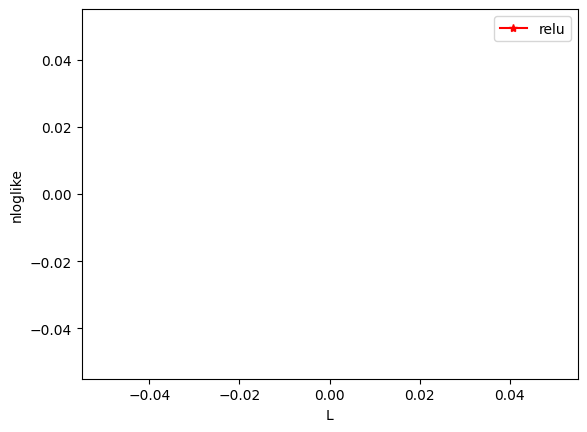

In [95]:
args_scores = Namespace(
    nloglike = True,
    gmean = False,
    max = False,
    min = False,
    median = False,
    pvalue_comulative = False,
    backtesting = False
)

iteration_number = 0
total_iterations = len(grid_parameters_datasets['L'])*len(grid_parameters_datasets['n'])*len(grid_parameters_datasets['activation'])
grid_dataset_results = []
for architecture in get_architecture(grid_parameters_datasets):
  # print iteration_number
  iteration_number = iteration_number + 1
  print("{}/{}".format(iteration_number, total_iterations))

  dataset_handler = DatasetHandler()
  score_handler = Score_Handler()

  # Generator MLP Parameters
  L, n, activation, Cb, Cw = unpack_architecture(architecture)
  width_list = create_constant_widths_list(L, n)


  # Instantiate Generator
  mlp = MLP(L, width_list, activation, Cb, Cw, seed = L, use_bias = False, use_generator_init = True)

  # Create Dataset
  dataset, _= dataset_handler.create_dataset_from_MLP_given_input(mlp, input)


  file_name = 'dataframe_data.csv'

  # Save the DataFrame to a CSV file
  dataset.to_csv(file_name, index=False)

  # Download the CSV file
  files.download(file_name)

  path = basepath + str(L) + "_" + activation + "/"
  gaussian_limit_json = create_or_load_gaussian_limit_for_each_predictors(path, args_datahandling, grid_parameters_predictors, input)


  mlpgenerator_datasetsimulation = MLPGeneratedDatasetSimulation(dataset_handler)
  if args_datahandling.save_dataset_on_cloud:
    # Save dataset description
    mlpgenerator_datasetsimulation.save_dataset_description_on_cloud(basepath)
    # Save dataset
    centered_dataset = dataset_handler.get_uncentered_dataset()
    path = basepath + str(L) + "_" + activation
    handle_dirs(path)
    filename = path + "/dataset.csv"
    with open(filename, 'w', encoding = 'utf-8-sig') as f:
      centered_dataset.to_csv(f, index = False)

  current_dataset_results = score_handler.compute_nloglike(dataset_handler, gaussian_limit_json)
  mlpgenerator_datasetsimulation.set_results(current_dataset_results)

  if args_datahandling.save_results_on_cloud:
    mlpgenerator_datasetsimulation.save_dataset_results_on_cloud(basepath)

  grid_dataset_results.append(mlpgenerator_datasetsimulation)

if args_datahandling.save_figures_on_cloud:
  lineplots(grid_dataset_results, basepath, args_scores)

In [ ]:
np.linalg.norm(input.iloc[:], axis=1, ord=2)

array([3.16227766, 3.16227766, 3.16227766, 3.16227766, 3.16227766,
       3.16227766, 3.16227766, 3.16227766, 3.16227766, 3.16227766,
       3.16227766, 3.16227766, 3.16227766, 3.16227766, 3.16227766,
       3.16227766, 3.16227766, 3.16227766, 3.16227766, 3.16227766,
       3.16227766, 3.16227766, 3.16227766, 3.16227766, 3.16227766,
       3.16227766, 3.16227766, 3.16227766, 3.16227766, 3.16227766,
       3.16227766, 3.16227766, 3.16227766, 3.16227766, 3.16227766,
       3.16227766, 3.16227766, 3.16227766, 3.16227766, 3.16227766,
       3.16227766, 3.16227766, 3.16227766, 3.16227766, 3.16227766,
       3.16227766, 3.16227766, 3.16227766, 3.16227766, 3.16227766,
       3.16227766, 3.16227766, 3.16227766, 3.16227766, 3.16227766,
       3.16227766, 3.16227766, 3.16227766, 3.16227766, 3.16227766,
       3.16227766, 3.16227766, 3.16227766, 3.16227766, 3.16227766,
       3.16227766, 3.16227766, 3.16227766, 3.16227766, 3.16227766,
       3.16227766, 3.16227766, 3.16227766, 3.16227766, 3.16227

In [ ]:
import numpy as np
import csv
from google.colab import files

In [ ]:
# Architettura per cui si vuole calcolare la matrice di covarianza del processo gaussiano.
L = 1
Cb = 0
Cw = 1
K = get_K_from_architecture(L, Cb, Cw, input)

file_name = 'matrix_data.csv'

# Save the matrix to a CSV file
with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(K)

# Download the CSV file
files.download(file_name)


# K è una matrice args.n_sample x args.n_sample.
# Il codice seguente seleziona la sottomatrice quadrata di K, di dimensione j,
# che va dall'elemento K[i][i] all'elemento K[i+j][i+j]

# Dimensione della sottomatrice quadrata che si vuole visualizzare.
j = 2

# Indice da cui partire per la selezione della sottomatrice quadrata che si vuole visualizzare.
i = 0

# NOTA: deve valere: i + j < args.n_sample
assert(i + j < args.n_sample)

sub_K = K[i:i+j, i:i+j]

print(sub_K)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[[0.5        0.17214406]
 [0.17214406 0.50000006]]


In [ ]:
print("Determinante di sub_K:")
print(np.linalg.det(sub_K))
print("\n")

print("Inversa di sub_K")
print(np.linalg.inv(sub_K))
print("\n")

print("Autovalori di sub_K (se sono reali, la parte immaginaria non viene mostrata):")
print(np.sort(np.linalg.eig(sub_K)[0]))
print("\n")

# print("Autovalori e corrispondenti autovettori di sub_K:")
#print((np.linalg.eig(sub_K)))
#print("\n")

Determinante di sub_K:
0.22036645


Inversa di sub_K
[[ 2.268948  -0.7811718]
 [-0.7811718  2.2689478]]


Autovalori di sub_K (se sono reali, la parte immaginaria non viene mostrata):
[0.32785597 0.6721441 ]


